## Improving Dataset
References
* https://github.com/aleju/imgaug
* http://blog.yhat.com/posts/image-processing-with-scikit-image.html
* http://scikit-image.org/docs/dev/user_guide/transforming_image_data.html
* https://bradmontgomery.net/blog/pythons-zip-map-and-lambda/
* http://stackoverflow.com/questions/3204245/how-do-i-convert-a-tuple-of-tuples-to-a-one-dimensional-list-using-list-comprehe
* https://github.com/sahiljuneja/Udacity-SDCND-Term-1/tree/master/P3-Behavioral-Cloning
* https://github.com/CYHSM/carnd
* https://github.com/udacity/self-driving-car
* https://github.com/udacity/self-driving-car/tree/master/steering-models/community-models/rambo
* http://stackoverflow.com/questions/40062770/adding-data-to-existing-h5py-file-along-new-axis-using-h5py
* https://indico.io/blog/tensorflow-in-practice-video-slides/
* https://indico.io/blog/the-good-bad-ugly-of-tensorflow/

In [1]:
import numpy as np
import sys
sys.path.append('../')
from driving_data import HandleData
import matplotlib.pyplot as plt
import os
import subprocess
import glob
import lmdb
from augment_batch import AugmentDrivingBatch
import random

import skimage
import skimage.filters
import skimage.color

LMDB_PATH = '/media/laraujo/BigLinuxPart/DatasetLMDB_7'
LMDB_PATH_DEST = '/media/laraujo/BigLinuxPart/DatasetLMDB_Balanced'
TFREC_PATH_DEST = '/media/laraujo/BigLinuxPart/Dataset_Balanced_7.tfrec'

### Read LMDB data

In [2]:
lst_labels_read = []
lst_imgs_read = []
env = lmdb.open(LMDB_PATH, readonly=True)
with env.begin() as txn:
    cursor = txn.cursor()
    for key, value in cursor:                
        key_str = key.decode('ascii')
        #print(key_str)
        if 'label' in key_str:            
            lst_labels_read.append(np.float32(np.asscalar(np.frombuffer(value, dtype=np.float32, count=1))))
        else:            
            # Get shape information from key name
            info_key = key_str.split('_')
            # Get image shape [2:None] means from index 2 to the end
            shape_img = tuple(map(lambda x:int(x) ,info_key[2:None]))            
            # Convert to float32
            lst_imgs_read.append(np.frombuffer(value, dtype=np.uint8).reshape(shape_img))  

### Get histogram of inputs
Observe from the histogram that almost all the actions are angle=0 on the steering wheel, the problem is that if we backpropagate this the network will find fine output always angle=0

Dataset size: 4180


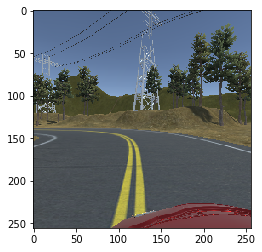

Wheel angle: 0.0
Number of unique elements: 2218
Most frequent angle: 0.0


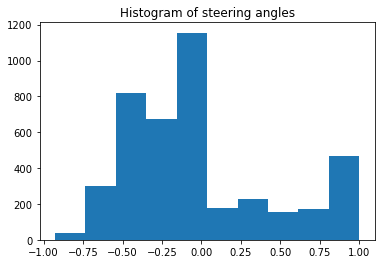

In [3]:
print('Dataset size:', len(lst_imgs_read))
rand_index = random.randint(0,len(lst_imgs_read)-1)
plt.imshow(lst_imgs_read[rand_index].astype(np.uint8))
plt.show()
print('Wheel angle:', lst_labels_read[rand_index])
unique_angles, counts = np.unique(lst_labels_read,return_counts=True)
print('Number of unique elements:',len(unique_angles))
most_frequent_angle = unique_angles[np.argmax(counts)]
print('Most frequent angle:',most_frequent_angle)
n_bins = len(unique_angles)*2
plt.hist(lst_labels_read)
plt.title("Histogram of steering angles")
plt.show()

### Select images from dataset where steering angle is 0,Left,Right

In [4]:
# Create a list with images and angles
list_img_angles = list(zip(lst_imgs_read, lst_labels_read))

# Select the items of the zip list where the angle is 0, left or right
list_img_angles_zeros = [(img,steering) for (img,steering) in list_img_angles if steering == 0]
list_img_angles_left = [(img,steering) for (img,steering) in list_img_angles if steering < 0]
list_img_angles_right = [(img,steering) for (img,steering) in list_img_angles if steering > 0]

# Display quantity
print('Number (angles==0)=%d'% len(list_img_angles_zeros))
print('Number (angles==Left)=%d'% len(list_img_angles_left))
print('Number (angles==Right)=%d'% len(list_img_angles_right))

Number (angles==0)=741
Number (angles==Left)=2199
Number (angles==Right)=1240


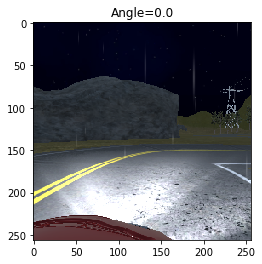

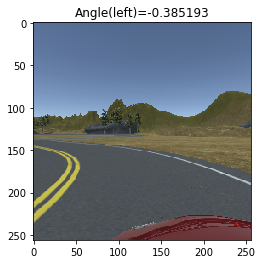

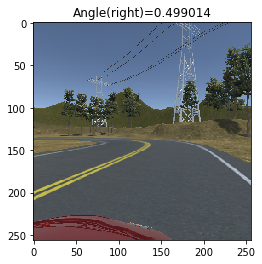

In [5]:
# Angle 0 example
[img,steering] = list_img_angles_zeros[random.randint(0,len(list_img_angles_zeros)-1)]
plt.imshow(img)
plt.title('Angle=' + str(steering))
plt.show()

# Angle (left) example
[img,steering] = list_img_angles_left[random.randint(0,len(list_img_angles_left)-1)]
plt.imshow(img)
plt.title('Angle(left)=' + str(steering))
plt.show()

# Angle (right) example
[img,steering] = list_img_angles_right[random.randint(0,len(list_img_angles_right)-1)]
plt.imshow(img)
plt.title('Angle(right)=' + str(steering))
plt.show()

## Balance dataset

In [6]:
def balance_dataset(list_img_angles, lst_labels_read, dec_factor=4.0):    
    # Make a copy of the original dataset
    balanced_dataset = list_img_angles
    
    # Get list of possible angles
    unique_angles, counts = np.unique(lst_labels_read,return_counts=True)
    print('Number of unique elements:',len(unique_angles))
    most_frequent_angle = unique_angles[np.argmax(counts)]
    
    # Get the mode of angles (Most repeated angle and how much....)
    mode_freq = np.max(counts)
    print('Most repeated angle is', unique_angles[np.argmax(counts)], 'frequency:', mode_freq)
    
    # For each possible angle
    for angle in unique_angles:                
        if angle != most_frequent_angle:
            # Get list of elements that have a particular angle
            list_curr_angle = [(img,steering) for (img,steering) in list_img_angles if steering == angle]
            
            num_elements = len(list_curr_angle)
            
            # Calculate how much shoud I grow
            factor = mode_freq / num_elements
            
            #print('Angle:',angle,'factor:',factor,'Number of elements',num_elements)
            
            # Grow by a factor the output list with the current elements
            for x in range(int(factor/dec_factor)):
                balanced_dataset.extend(list_curr_angle)
    
    return balanced_dataset

In [7]:
list_img_angles_balanced = balance_dataset(list_img_angles, lst_labels_read)

Number of unique elements: 2218
Most repeated angle is 0.0 frequency: 741


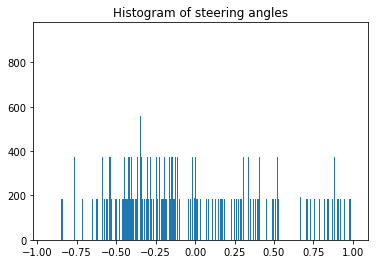

In [8]:
ys_balanced = []
xs_balanced = []
for (tup_element) in list_img_angles_balanced:
    img,steer = tup_element
    ys_balanced.append(steer)
    xs_balanced.append(img)

plt.hist(np.array(ys_balanced),bins=n_bins)
plt.title("Histogram of steering angles")
plt.show()

### Calculate sizes

In [9]:
# get size in bytes of lists
size_bytes_images = xs_balanced[0].nbytes * len(xs_balanced)
size_bytes_labels = ys_balanced[0].nbytes * len(ys_balanced)
total_size = size_bytes_images + size_bytes_labels
print('Total size(bytes): %d' % (size_bytes_images+size_bytes_labels))
print('Number of elements:', len(ys_balanced))
print('Type of images: ', type(xs_balanced), 'of', xs_balanced[0].dtype)
print('Type of labels: ', type(ys_balanced), 'of', ys_balanced[0].dtype)

# Convert shape tupple into string separated with '_
shape_img = xs_balanced[0].shape
shape_str = '_'.join([str(dim) for dim in shape_img])
print('Image shape',shape_img)
print('Image size in bytes',xs_balanced[0].nbytes)

Total size(bytes): 81294146700
Number of elements: 413475
Type of images:  <class 'list'> of uint8
Type of labels:  <class 'list'> of float32
Image shape (256, 256, 3)
Image size in bytes 196608


### Shuffle random dataset

In [10]:
random.shuffle(list_img_angles_balanced)

### Sava Balanced dataset to TFRecord

In [11]:
HandleData.save_tfrecord(list_img_angles_balanced, filename=TFREC_PATH_DEST)

### Save Balanced dataset to LMDB

In [ ]:
# Open LMDB file
# You can append more information up to the total size.
env = lmdb.open(LMDB_PATH_DEST, map_size=total_size*2)
idx_lmdb = 0
# Get a write lmdb transaction, lmdb store stuff with a key,value(in bytes) format
with env.begin(write=True) as txn:
    # Iterate on batch    
    for (tup_element) in list_img_angles_balanced:
        img,steer = tup_element        
        str_id = 'label_{:08}'.format(idx_lmdb)   
        # Encode shape information on key
        img_id = ('img_{:08}_' + shape_str).format(idx_lmdb)           
        # The current type of steer is np.float32 and img ndarray of float32
        txn.put(bytes(str_id.encode('ascii')),steer.tobytes())                
        txn.put(bytes(img_id.encode('ascii')),img.tobytes())                        
        idx_lmdb += 1